In [123]:
# Imports

# Standard library
import os
import random
import warnings
import json
import base64
from io import BytesIO

# Data processing
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt

# Deep learning
import torch
from torchvision import models, transforms

# Image processing
from PIL import Image, ImageOps, ImageFilter

# Progress bar
from tqdm import tqdm

# Hugging Face Datasets
from datasets import load_dataset, Dataset

# OpenAI API
from openai import OpenAI

# Machine learning utilities
from sklearn.model_selection import StratifiedShuffleSplit

warnings.filterwarnings("ignore")

In [137]:
# Parameters and Constants
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

TARGET_SIZE = (224, 224)
DATASET_NAME = 'jbourcier/fgsc23'
IMAGE_COL    = 'image'                       # HF column name for images
LABEL_COL    = 'label'                       # HF column name for labels
CLASS_COL    = ['class_name']                # HF column name for class names
DUPLICATION_THRESHOLD = 0.95
IMG_SIZE     = (224, 224)
APPLY_BLUR = True               # toggle Gaussian blur
BLUR_RADIUS_RANGE = (0.0, 2.0)
APPLY_HAZE = True               # toggle white‐haze overlay
HAZE_ALPHA_RANGE = (0.0, 0.4)
BATCH_SIZE   = 32
NUM_EPOCHS   = 10
LEARNING_RATE = 1e-4
DEVICE       = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Load Dataset
ds: Dataset = load_dataset(DATASET_NAME, split="train")

# Display Dataset Information
print(ds)

Dataset({
    features: ['image', 'label'],
    num_rows: 4080
})


In [4]:
# Mapping integer labels (0–22) to human-readable ship class names from Zhang et al. (2020)
label_map = {
    0:  "Non-ship",
    1:  "Aircraft carrier",
    12:  "Destroyer",
    16:  "Landing craft",
    17:  "Frigate",
    18:  "Amphibious transport dock",
    19:  "Cruiser",
    20:  "Tarawa-class amphibious assault ship",
    21:  "Amphibious assault ship",
    22:  "Command ship",
    2: "Submarine",
    3: "Medical ship",
    4: "Combat boat",
    5: "Auxiliary ship",
    6: "Container ship",
    7: "Car carrier",
    8: "Hovercraft",
    9: "Bulk carrier",
    10: "Oil tanker",
    11: "Fishing boat",
    13: "Passenger ship",
    14: "Liquefied gas ship",
    15: "Barge"
}

# Add a new column 'class_name' to the dataset with human-readable labels
def map_label(example):
    example['class_name'] = label_map.get(example['label'], "Unknown")
    return example

ds = ds.map(map_label)

# Display Dataset Information
print(ds)

Dataset({
    features: ['image', 'label', 'class_name'],
    num_rows: 4080
})


Class distribution (sorted):
class_name
Destroyer                               542
Non-ship                                484
Bulk carrier                            343
Frigate                                 295
Cruiser                                 293
Submarine                               238
Auxiliary ship                          225
Aircraft carrier                        166
Oil tanker                              165
Amphibious assault ship                 154
Combat boat                             143
Hovercraft                              120
Landing craft                           108
Fishing boat                            102
Container ship                          100
Liquefied gas ship                       94
Amphibious transport dock                90
Command ship                             89
Tarawa-class amphibious assault ship     88
Passenger ship                           88
Car carrier                              72
Barge                               

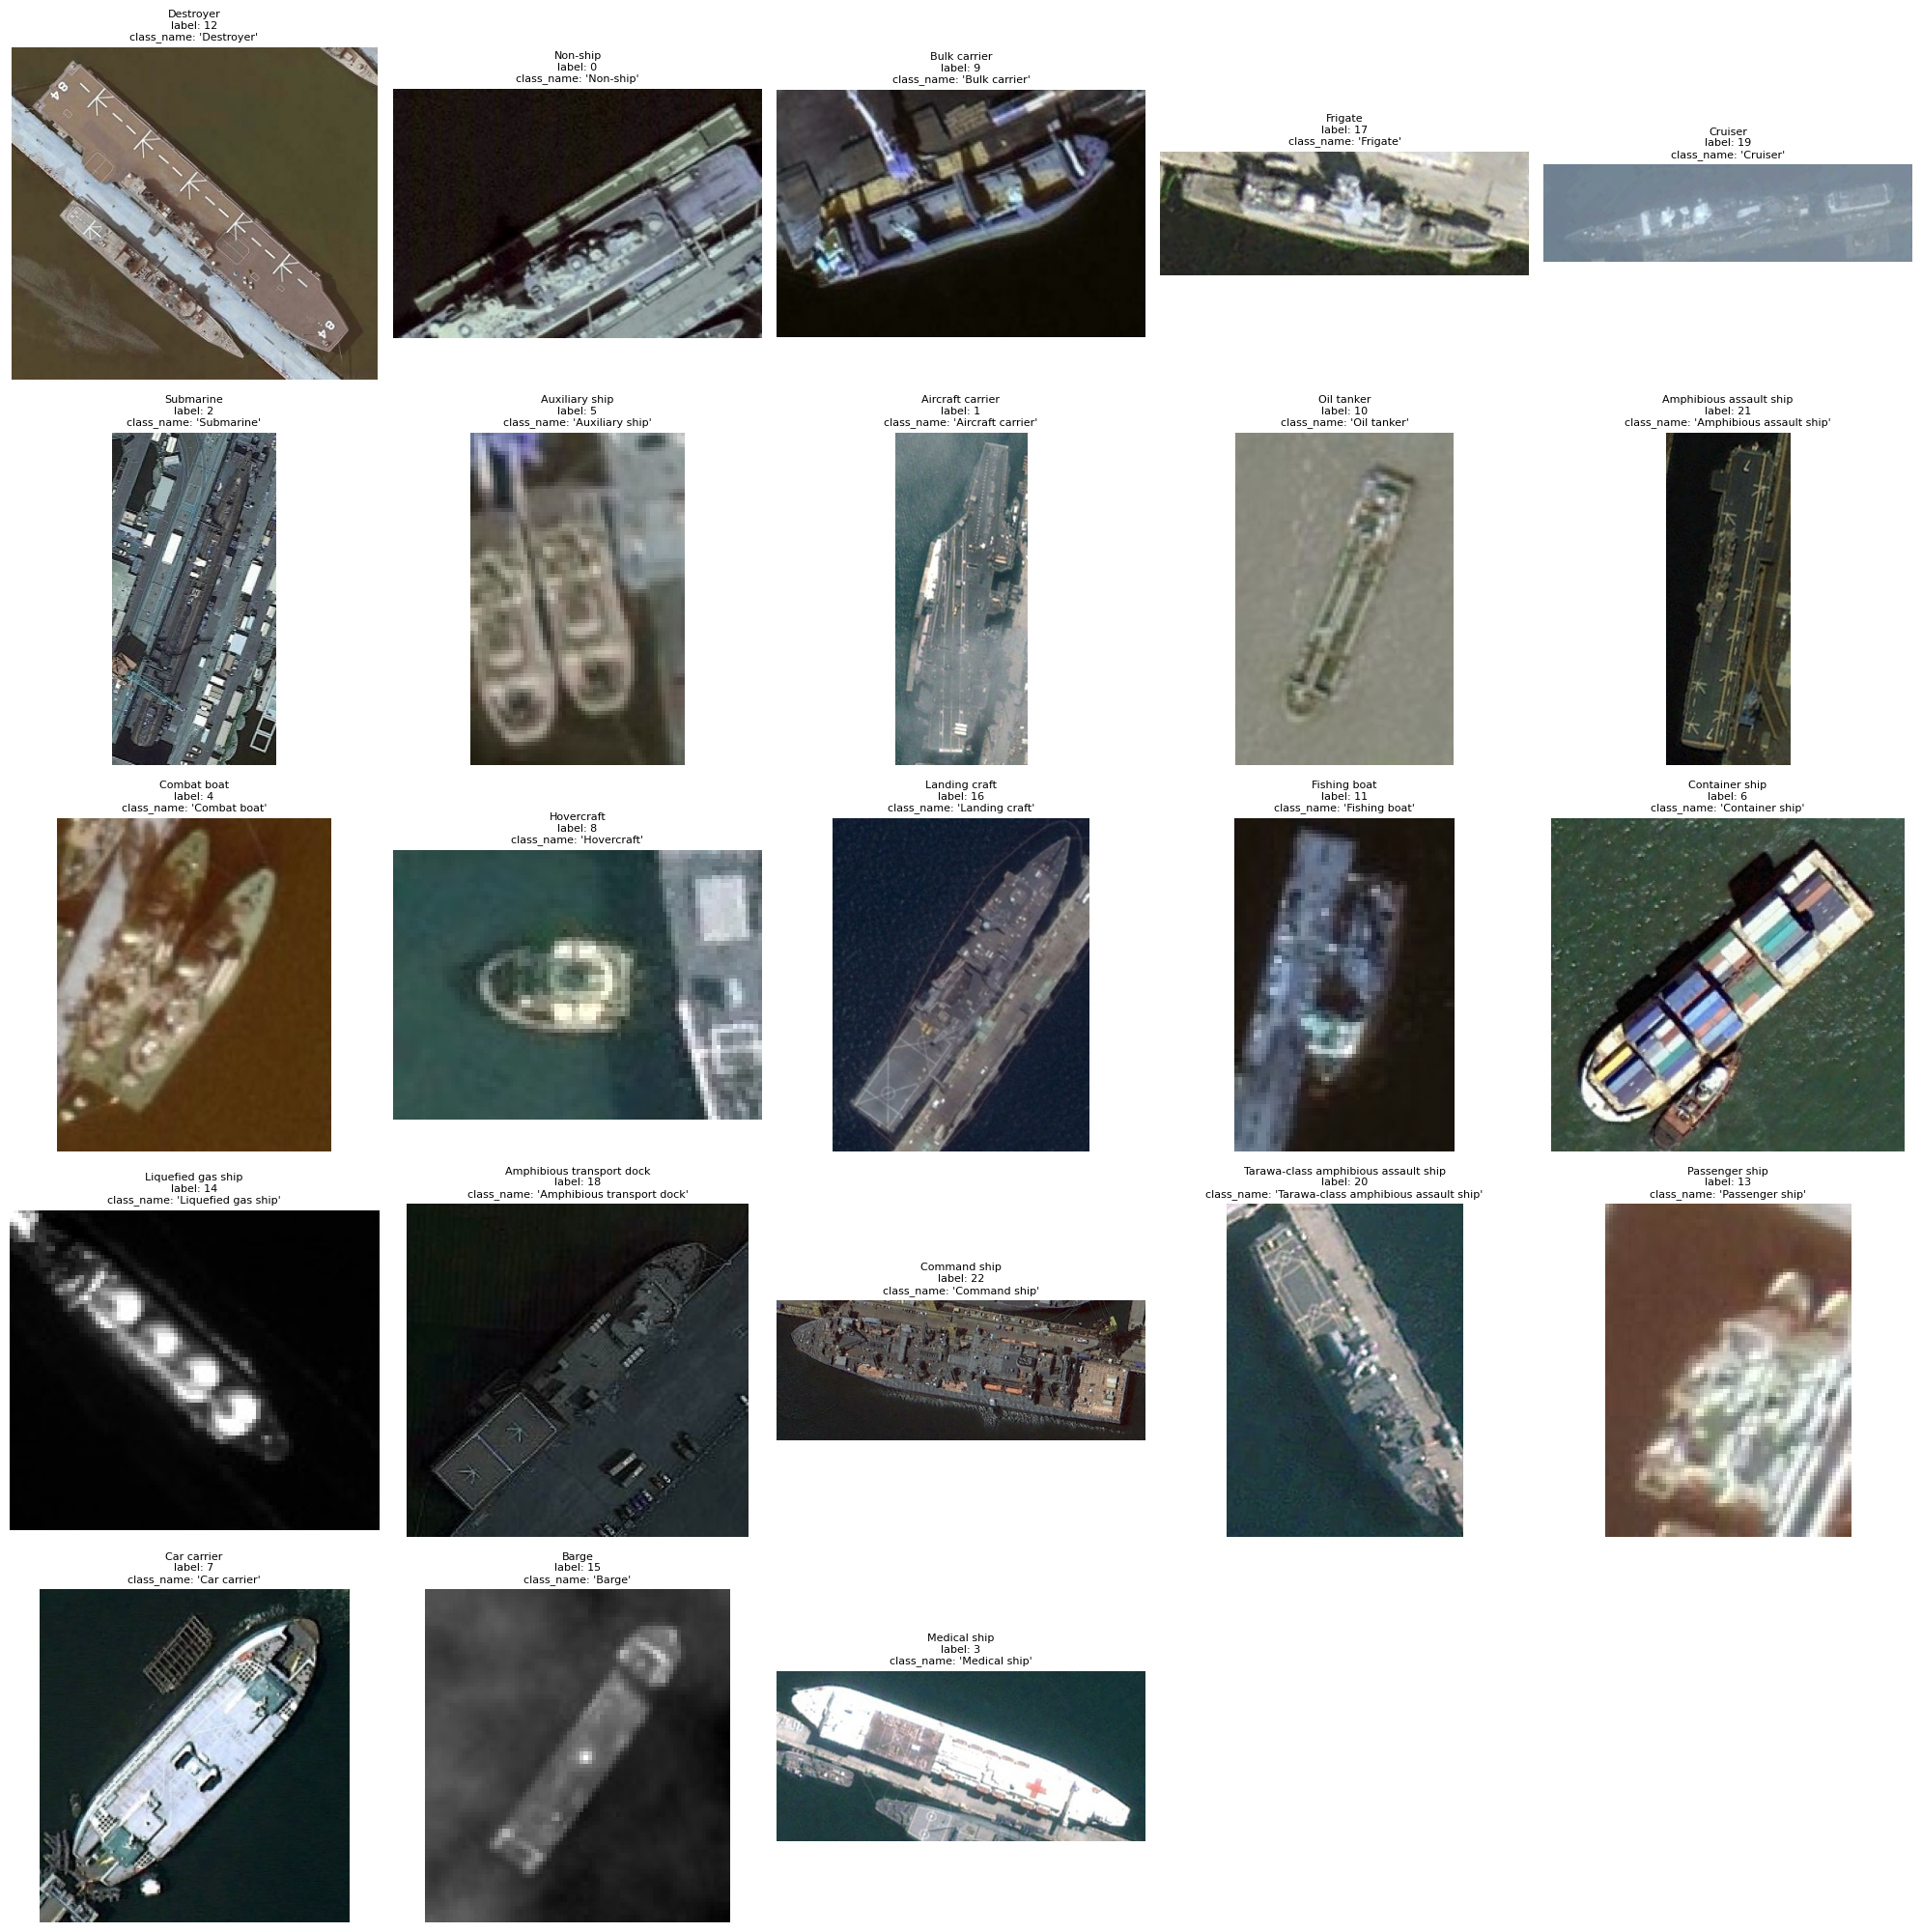

In [5]:
# Inspect Dataset

# Print class distribution sorted by sample count
class_counts = ds.to_pandas()['class_name'].value_counts().sort_values(ascending=False)
print("Class distribution (sorted):")
print(class_counts)

def plot_one_image_per_class(ds, class_counts, n_rows=5, n_cols=5):
    """
    Plots one image per class in a grid, with all features printed above each image.

    Args:
        ds: Dataset object.
        class_counts: Pandas Series of class counts, sorted.
        n_rows: Number of rows in grid.
        n_cols: Number of columns in grid.
    """
    n_classes = len(class_counts)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))

    for i, class_name in enumerate(class_counts.index):
        row, col = divmod(i, n_cols)
        ax = axes[row, col]
        idx = int(ds.to_pandas().query("class_name == @class_name").index[0])
        example = ds[idx]
        img = example['image']

        # Prepare feature string
        feature_str = "\n".join([f'{k}: {repr(v)}' for k, v in example.items() if k != 'image'])

        ax.imshow(img)
        ax.set_title(f"{class_name}\n{feature_str}", fontsize=8)
        ax.axis('off')

    # Hide unused subplots if any
    for j in range(n_classes, n_rows * n_cols):
        row, col = divmod(j, n_cols)
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

# Call the function to plot
plot_one_image_per_class(ds, class_counts, n_rows=5, n_cols=5)

In [6]:
# Deduplication of Near‑Identical Samples

# 1. Prepare transform + MobileNet backbone
transform = transforms.Compose([
    transforms.Resize(TARGET_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.485, .456, .406],
                         std=[.229, .224, .225]),
])

mobilenet = models.mobilenet_v3_large(
    weights=models.MobileNet_V3_Large_Weights.DEFAULT
)
backbone = torch.nn.Sequential(
    mobilenet.features,
    mobilenet.avgpool
).eval()

# 2. Iterate once to collect embeddings for RGB images
N = len(ds)

# infer embedding dimension
with torch.no_grad():
    dummy = torch.zeros(1, 3, *TARGET_SIZE)
    emb_dim = backbone(dummy).view(1, -1).shape[1]

# Preallocate with max possible size, will trim later
embeddings = torch.zeros((N, emb_dim), dtype=torch.float32)
labels     = np.zeros(N, dtype=int)
rgb_indices = []  # map from row→original idx in ds
row = 0

for idx in tqdm(range(N), desc="Computing embeddings"):
    img = ds[idx]["image"]
    if img.mode != "RGB":
        continue

    label = ds[idx]["label"]
    img_t = transform(img).unsqueeze(0)
    with torch.no_grad():
        feat = backbone(img_t).view(1, -1)
        feat = torch.nn.functional.normalize(feat, dim=1)

    embeddings[row] = feat
    labels[row]     = label
    rgb_indices.append(idx)
    row += 1

# trim to actual size
embeddings = embeddings[:row]
labels     = labels[:row]

# 3. Find near‐duplicate pairs within each class
to_remove = set()

for cls in np.unique(labels):
    cls_pos = np.where(labels == cls)[0]
    E = embeddings[cls_pos]
    sims = E @ E.T  # cosine similarities
    n = sims.shape[0]

    for i in range(n):
        for j in range(i+1, n):
            if sims[i, j] > DUPLICATION_THRESHOLD:
                # drop the *later* one j
                drop_idx = rgb_indices[cls_pos[j]]
                to_remove.add(drop_idx)

print(f"Dropping {len(to_remove)} near‐duplicates from dataset")

# 4. Filter out those indices from ds
ds = ds.filter(
    lambda _, idx: idx not in to_remove,
    with_indices=True
)

# 5. Save removed indices to CSV
removed_indices_df = pd.DataFrame({'removed_idx': sorted(to_remove)})
removed_indices_path = os.path.join("data/", "removed_indices.csv")
removed_indices_df.to_csv(removed_indices_path, index=False)

Computing embeddings: 100%|██████████| 4080/4080 [05:24<00:00, 12.59it/s]


Dropping 81 near‐duplicates from dataset


Map:   0%|          | 0/3999 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3999 [00:00<?, ? examples/s]

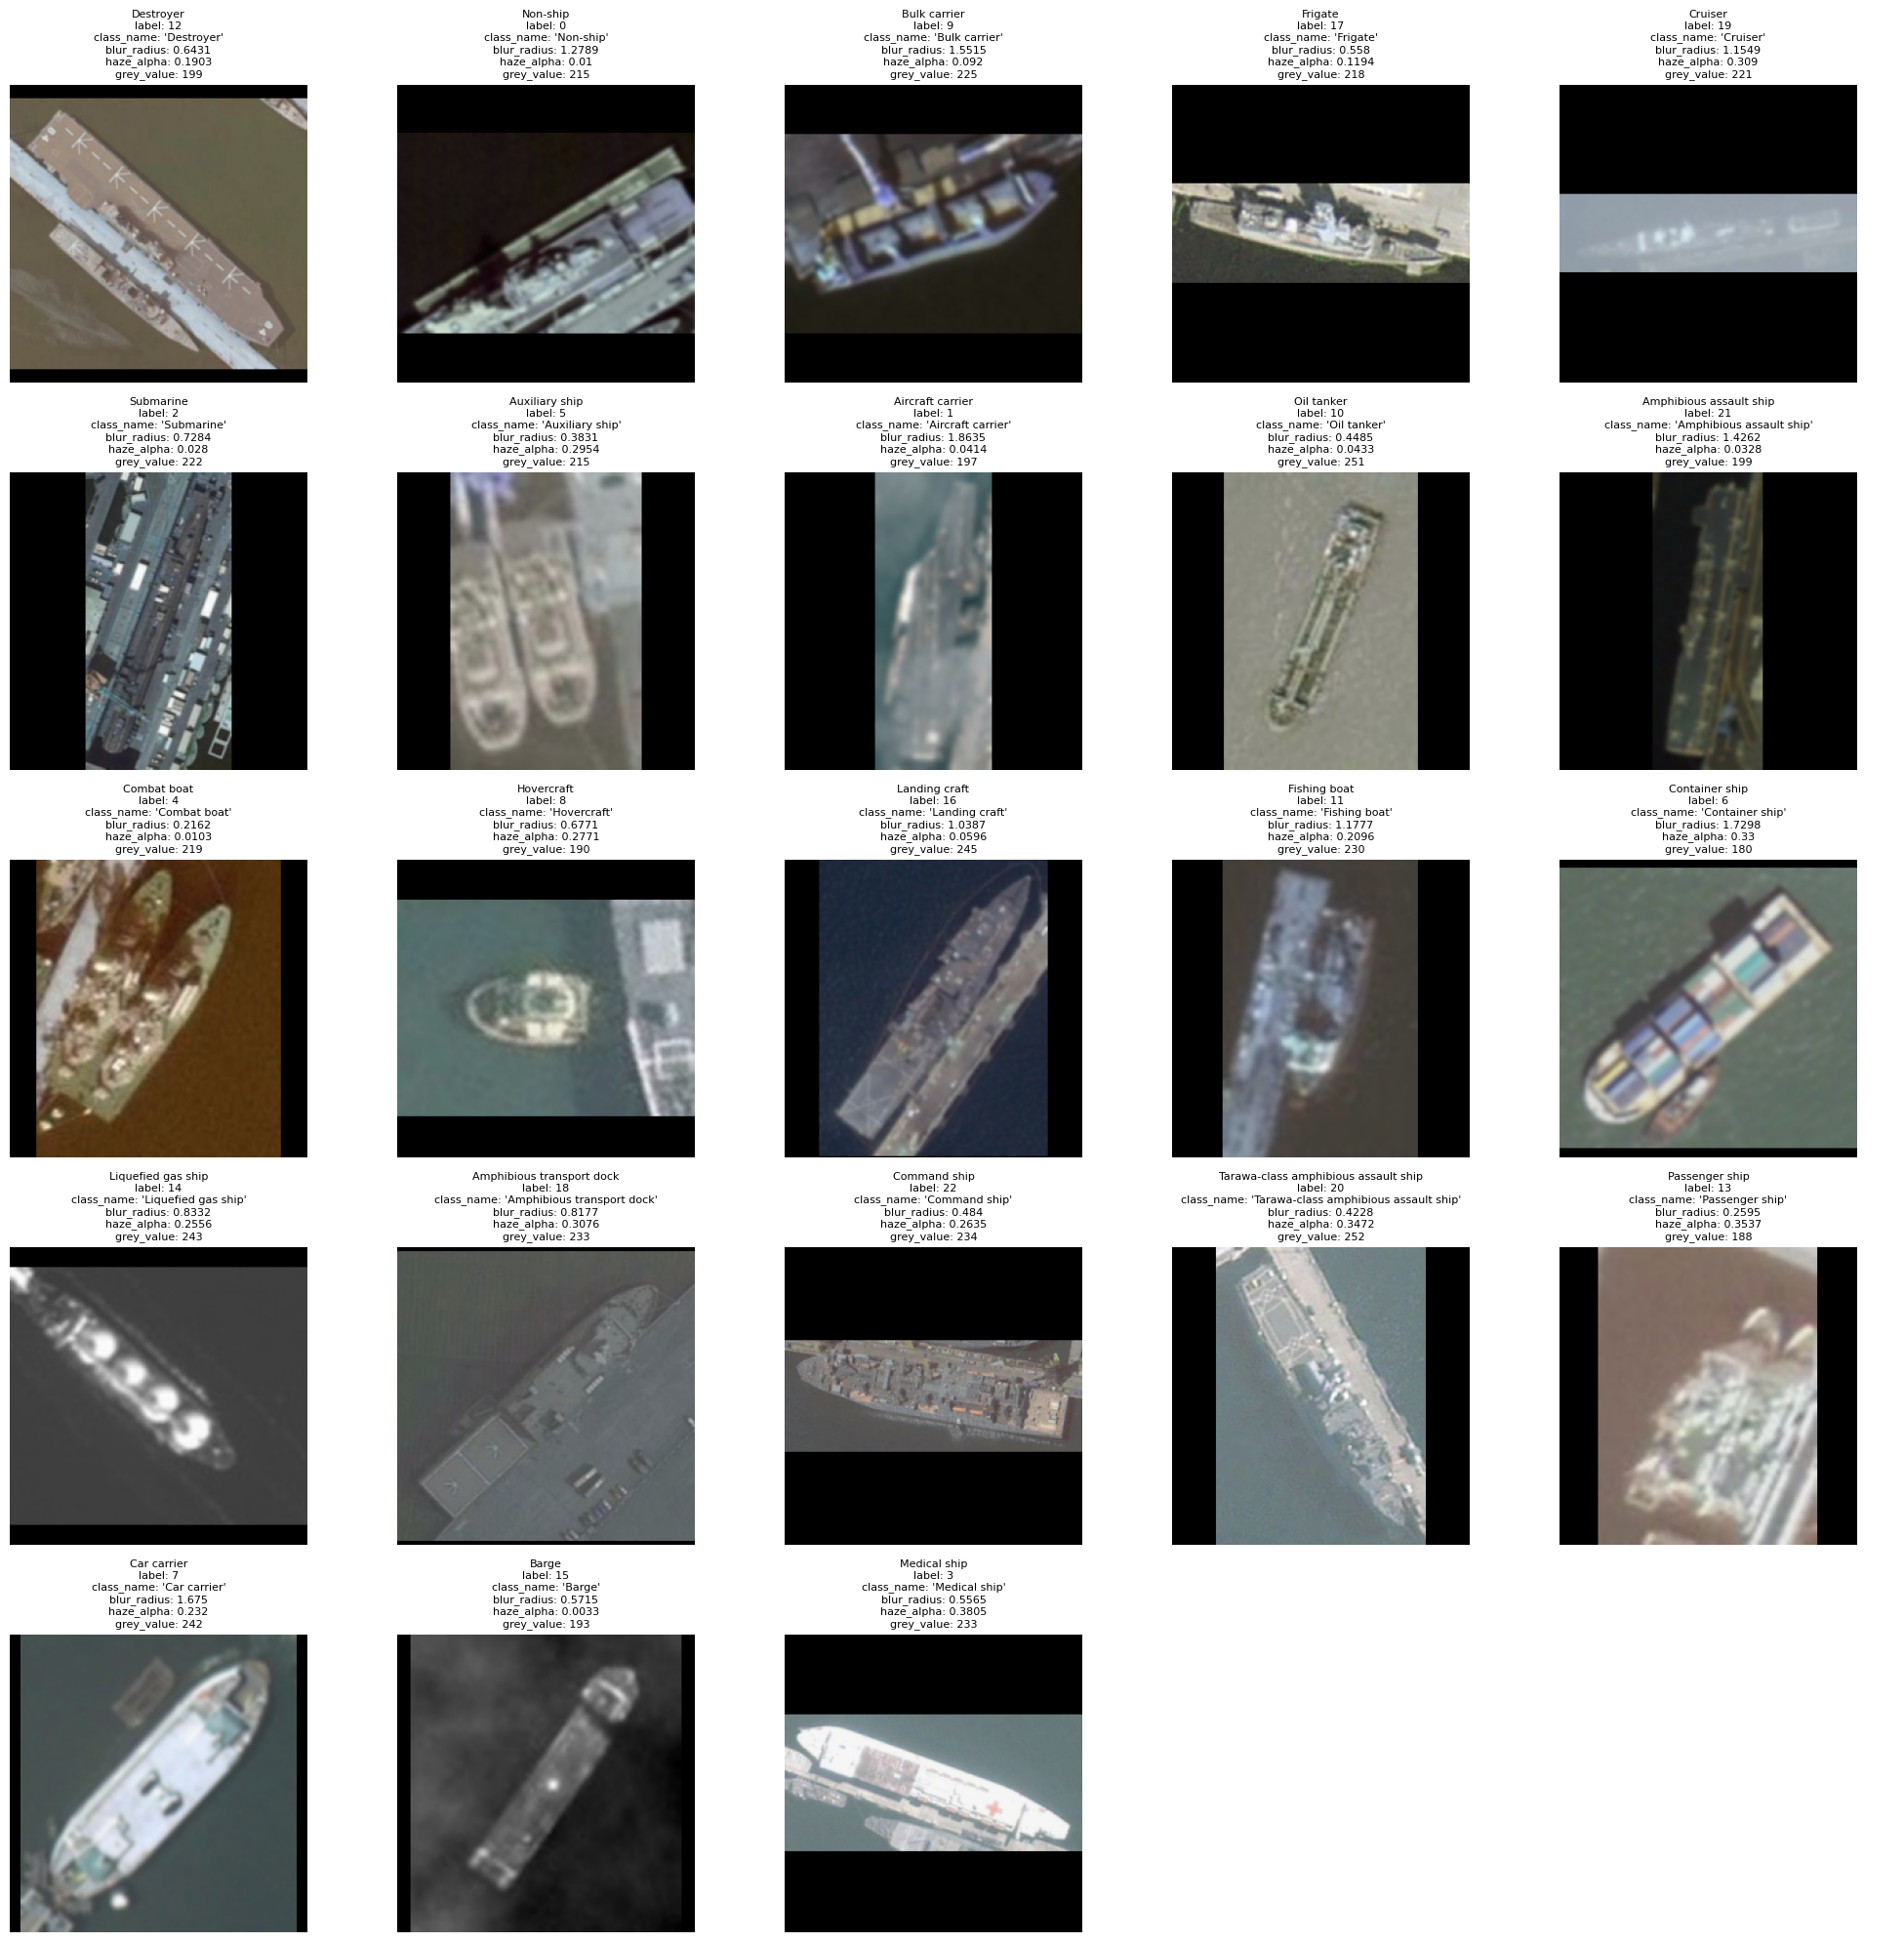

In [7]:
# Apply Distortions, Resizing, and Padding, and save distortion parameters

def preprocess(example):
    # 1) load & ensure RGB
    img = example["image"].convert("RGB")

    # 2) resize to IMG_SIZE
    iw, ih = img.size
    tw, th = IMG_SIZE
    scale = min(tw / iw, th / ih)
    nw, nh = int(iw * scale), int(ih * scale)
    img_resized = img.resize((nw, nh), Image.LANCZOS)

    # 3) optional Gaussian blur
    blur_radius = None
    if APPLY_BLUR:
        blur_radius = random.uniform(*BLUR_RADIUS_RANGE)
        img_resized = img_resized.filter(ImageFilter.GaussianBlur(blur_radius))

    # 4) optional white haze (blend with white overlay)
    haze_alpha = None
    grey_value = None
    if APPLY_HAZE:
        haze_alpha = random.uniform(*HAZE_ALPHA_RANGE)
        grey_value = random.randint(180, 255)
        grey_overlay = Image.new("RGB", img_resized.size, (grey_value, grey_value, grey_value))
        img_resized = Image.blend(img_resized, grey_overlay, alpha=haze_alpha)

    # 5) pad to IMG_SIZE
    pad_left   = (tw - nw) // 2
    pad_top    = (th - nh) // 2
    pad_right  = tw - nw - pad_left
    pad_bottom = th - nh - pad_top
    img_padded = ImageOps.expand(img_resized,
                                 border=(pad_left, pad_top, pad_right, pad_bottom),
                                 fill=(0, 0, 0))

    img_out = img_padded

    # 6) overwrite and return, add distortion parameters
    example["image"] = img_out
    example["blur_radius"] = round(blur_radius, 4) if blur_radius is not None else None
    example["haze_alpha"] = round(haze_alpha, 4) if haze_alpha is not None else None
    example["grey_value"] = grey_value
    return example

# --- Apply to your Dataset ---
ds = ds.map(preprocess, batched=False)

# Persist to disk in the same Arrow+image format:
ds.save_to_disk("data/preprocessed_dataset/")

# Save metadata (labels + distortion parameters) to CSV
metadata_df = ds.to_pandas()[["label", "class_name", "blur_radius", "haze_alpha", "grey_value"]]
metadata_path = os.path.join("data/", "preprocessed_metadata.csv")
metadata_df.to_csv(metadata_path, index=False)

# Plot one image per class in a grid
plot_one_image_per_class(ds, class_counts, n_rows=5, n_cols=5)

Scoring 100 random images: 100%|██████████| 3999/3999 [1:04:13<00:00,  1.04it/s]

Saved all qualities to image_qualities.csv


Saving the dataset (0/1 shards):   0%|          | 0/3999 [00:00<?, ? examples/s]

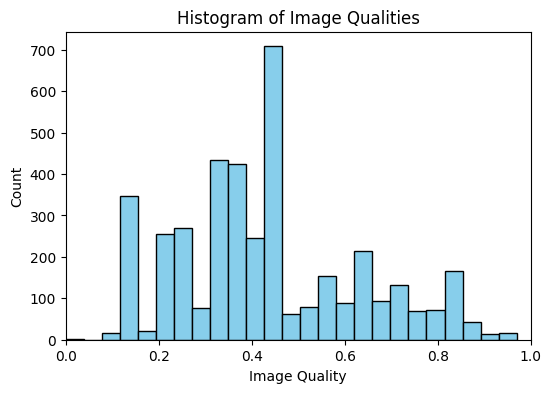

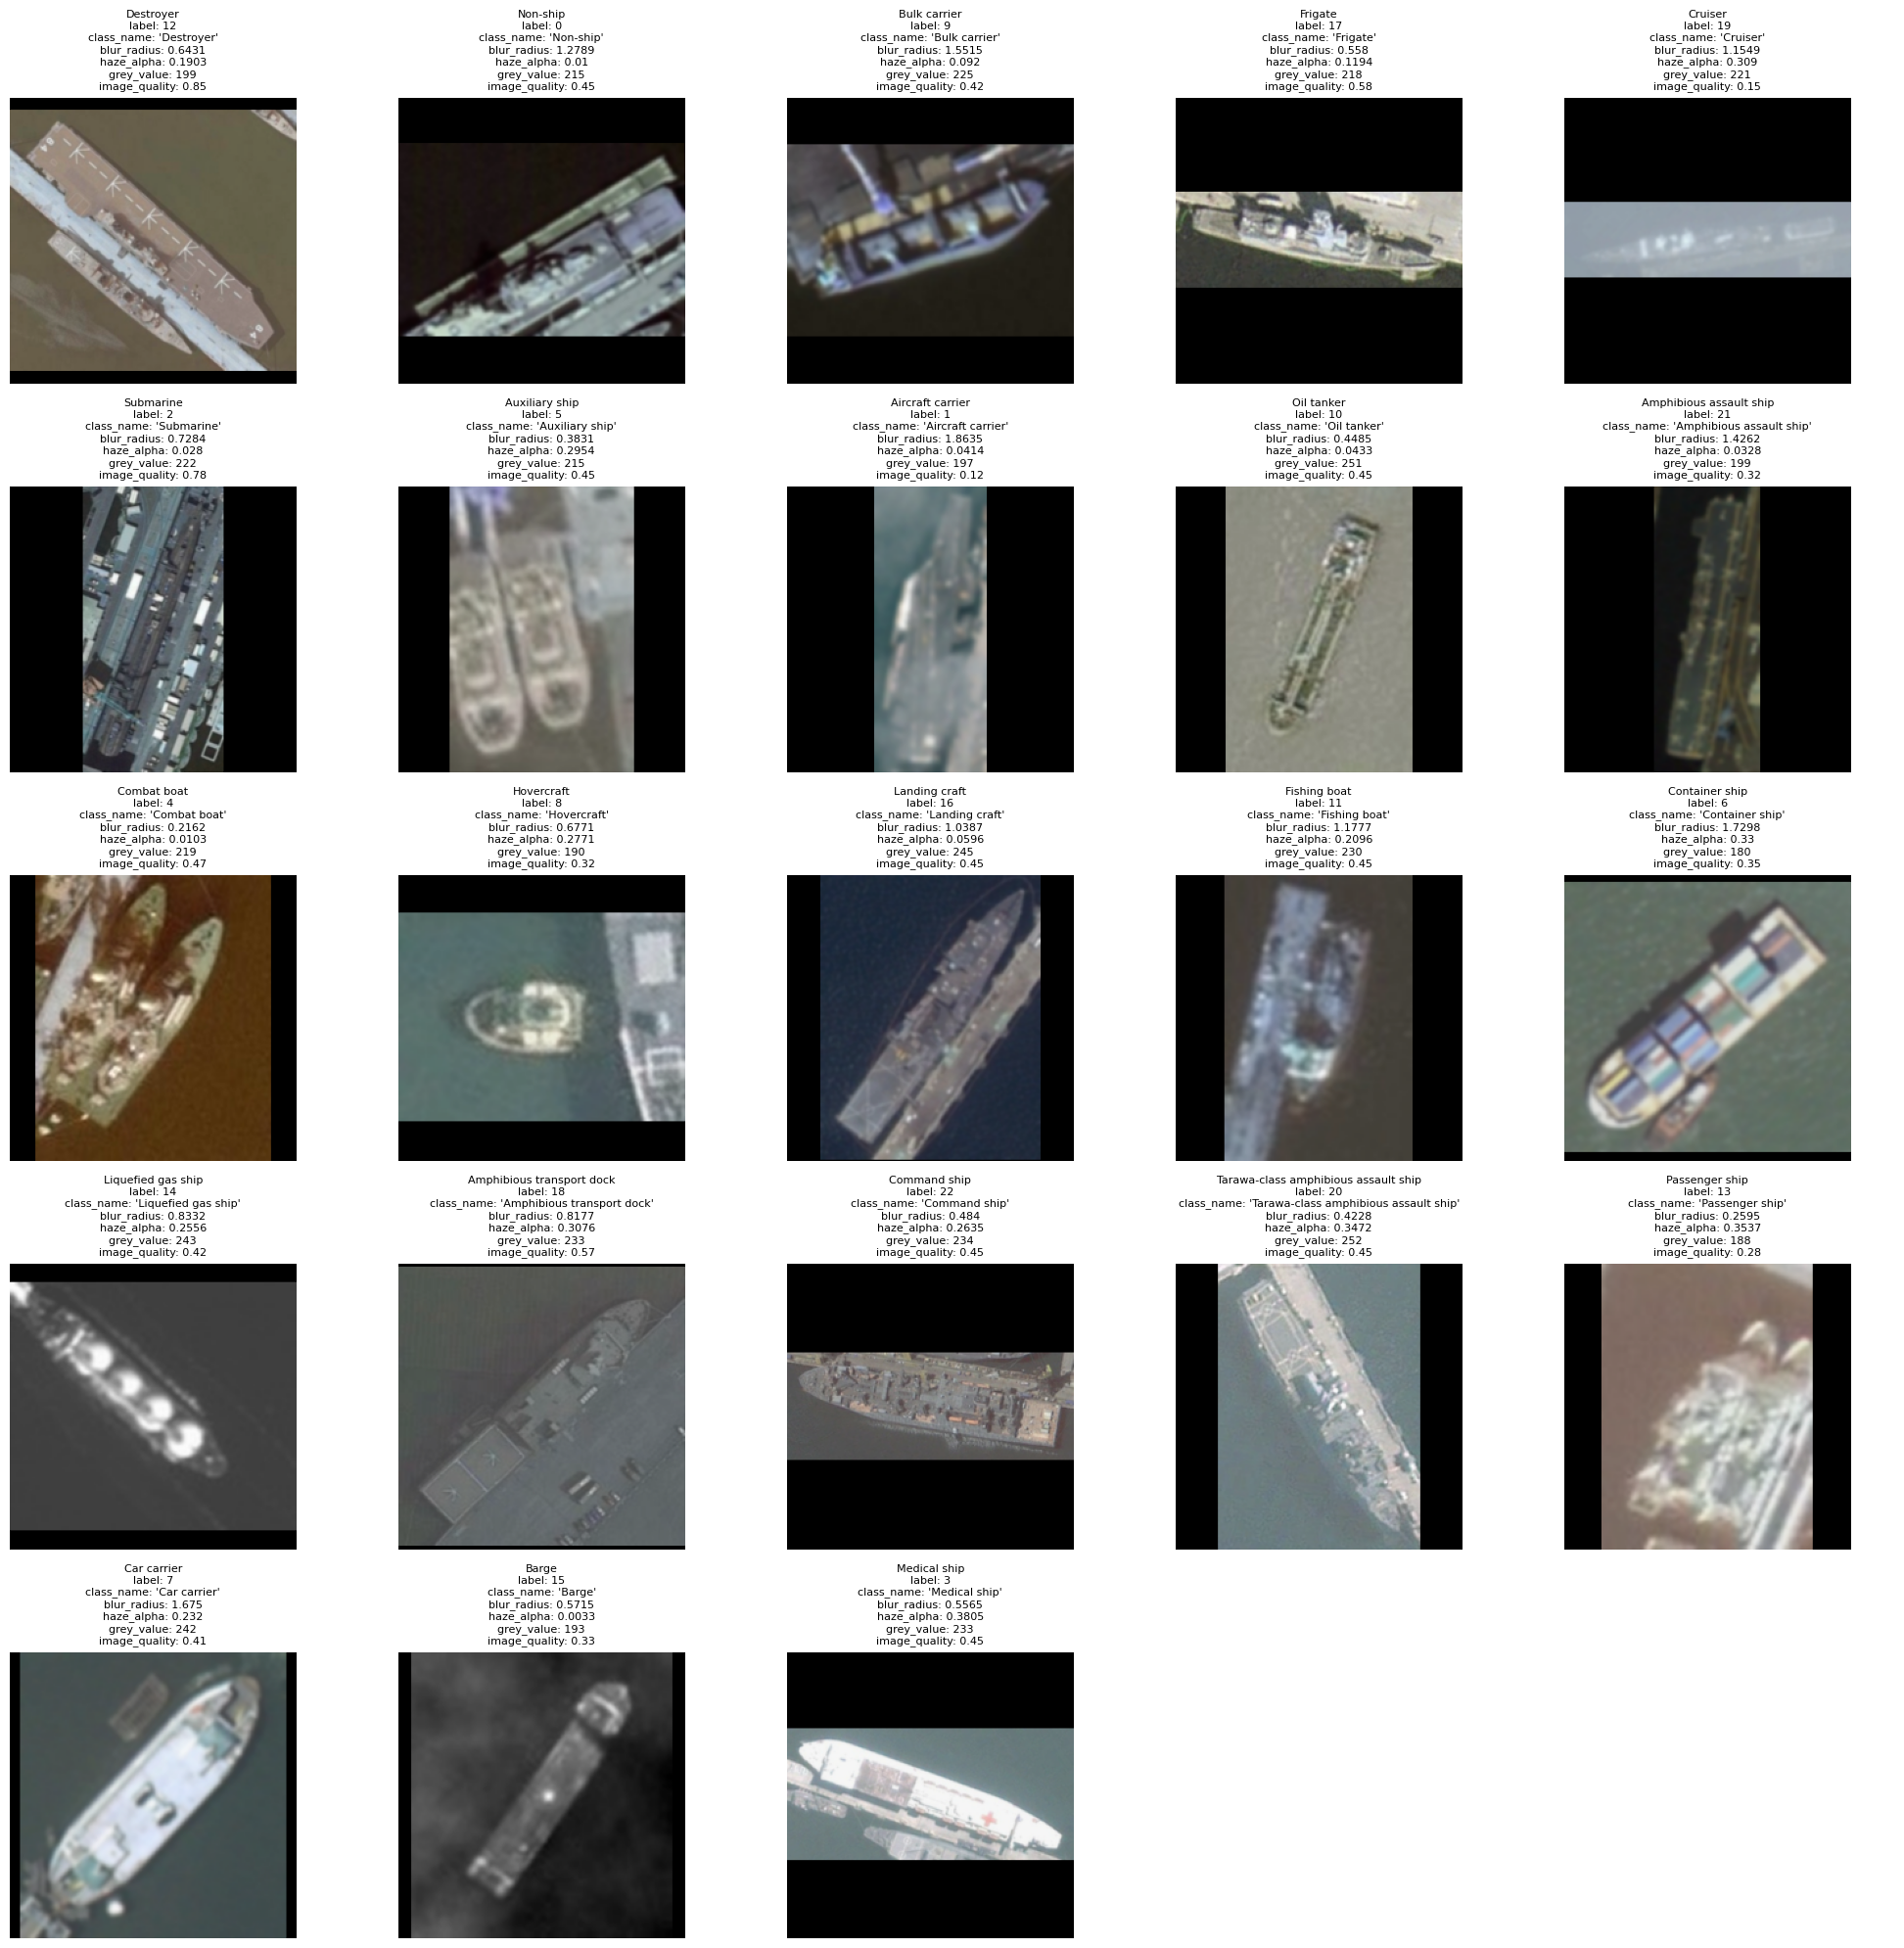

In [121]:
# Compute image qualities via OpenAI vision-capable model

# 0) Set API key
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

# 1) Helper to convert PIL image to data-URL base64
def pil_to_data_uri(img):
    buffer = BytesIO()
    img.save(buffer, format="PNG")
    b64 = base64.b64encode(buffer.getvalue()).decode("utf-8")
    return f"data:image/png;base64,{b64}"

# 2) System prompt
PROMPT = """
You are an expert satellite/UAV imagery quality assessor whose job is to support automated ship classification.  
The downstream classifier must distinguish among many military and civilian ship types—aircraft carriers, destroyers, frigates, container ships, etc.—some of which look very similar at low resolution or under blur.

For each image I show you (always containing a ship), output exactly one JSON field:
  • "quality": a float between 0.00 and 1.00 (1.00 = perfectly clear for distinguishing ship classes, 0.00 = totally unusable).

Penalize any of these degradations:
- Blur or defocus
- Sensor noise or grain
- JPEG/block compression artifacts
- Atmospheric haze or low contrast
- Clouds or partial occlusion

**Use at least two decimal places, and vary your answers**—do not pick the same value repeatedly.  Spread your scores throughout the range according to perceived quality.  

Do not output anything else, only the JSON in this exact format: {"quality": value}
"""

# 3) Map function to call OpenAI and append quality
def get_quality(example):
    # encode PIL image to data URI
    data_uri = pil_to_data_uri(example["image"])
    # build messages
    messages = [
        {
            "role": "system",
            "content": PROMPT
        },
        {
            "role": "user",
            "content": [
                {
                    "type": "image_url",
                    "image_url": {
                        "url": data_uri
                    },
                }
            ]
        }
    ]

    # call chat completion
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=messages,
        temperature=0.7,
        max_tokens=100
    )
    # parse JSON
    try:
        content = response.choices[0].message.content.strip()
        data = json.loads(content)
        quality = float(data["quality"])
        return quality
    except Exception as e:
        return None

# Compute OpenAI quality score for all images in ds and update dataset
image_qualities = []
for idx in tqdm(range(len(ds)), desc="Scoring 100 random images"):
    example = {"image": ds[idx]["image"], "idx": idx}
    result = get_quality(example)
    retries = 0
    while result is None and retries < 50:
        result = get_quality(example)
        retries += 1
    if result is not None:
        image_qualities.append(result)
    else:
        print(f"Failed to get quality for idx {idx} after {retries+1} attempts")
        image_qualities.append(0.5)
    
# Add image_quality feature to ds
ds = ds.add_column("image_quality", image_qualities)

# Save all qualities to CSV
df_q = pd.DataFrame(image_qualities)
df_q.columns = ["image_quality"]
df_q.index.name = "idx"
df_q.to_csv("data/image_qualities.csv", index=True, header=["image_quality"])
print("Saved all qualities to image_qualities.csv")

# Save enriched dataset
ds.save_to_disk("data/preprocessed_dataset_with_quality/")

# Plot histogram of image qualities
plt.figure(figsize=(6, 4))
plt.hist(image_qualities, bins=25, color='skyblue', edgecolor='black')
plt.xlabel('Image Quality')
plt.ylabel('Count')
plt.title('Histogram of Image Qualities')
plt.xlim(0, 1)
plt.show()

# Plot one image per class in a grid
plot_one_image_per_class(ds, class_counts, n_rows=5, n_cols=5)

Saving the dataset (0/1 shards):   0%|          | 0/2399 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/800 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/800 [00:00<?, ? examples/s]

Train set size: 2399
Validation set size: 800
Test set size: 800


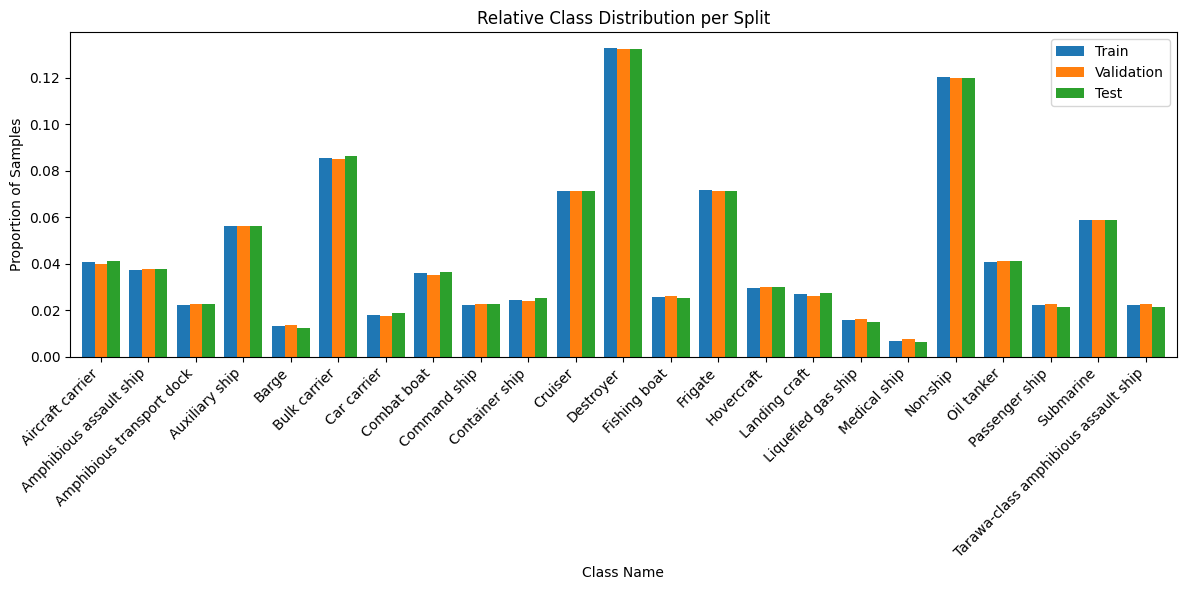

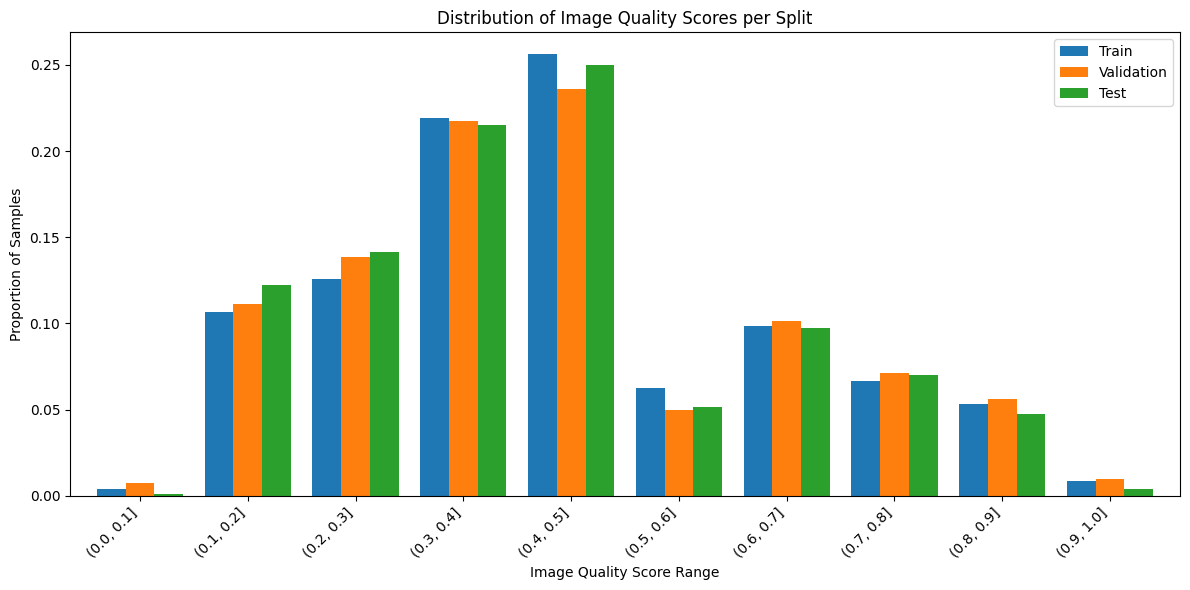

In [139]:
# Define split ratios for sufficient calibration and testing
val_ratio = 0.2
test_ratio = 0.2

# Get labels array for stratification
labels = ds.to_pandas()['label'].values

# First stratified split: train vs. (val+test)
sss = StratifiedShuffleSplit(n_splits=1, test_size=(val_ratio + test_ratio))
train_idx, temp_idx = next(sss.split(np.zeros(len(labels)), labels))

# Second stratified split: within the temp set, separate val and test
temp_labels = labels[temp_idx]
sss2 = StratifiedShuffleSplit(
    n_splits=1,
    test_size=test_ratio / (val_ratio + test_ratio),
)
val_sub_idx, test_sub_idx = next(sss2.split(np.zeros(len(temp_labels)), temp_labels))
val_idx = temp_idx[val_sub_idx]
test_idx = temp_idx[test_sub_idx]

# Create and save splits
ds_train = ds.select(train_idx)
ds_val   = ds.select(val_idx)
ds_test  = ds.select(test_idx)

ds_train.save_to_disk("data/train_dataset/")
ds_val.save_to_disk("data/val_dataset/")
ds_test.save_to_disk("data/test_dataset/")

# Print split sizes
print(f"Train set size: {len(ds_train)}")
print(f"Validation set size: {len(ds_val)}")
print(f"Test set size: {len(ds_test)}")

# Compute relative class distributions for each split
dist_train = ds_train.to_pandas()['class_name'].value_counts(normalize=True).sort_index()
dist_val   = ds_val.to_pandas()['class_name'].value_counts(normalize=True).sort_index()
dist_test  = ds_test.to_pandas()['class_name'].value_counts(normalize=True).sort_index()

# Combine into a single DataFrame
dist_df = pd.DataFrame({
    'Train': dist_train,
    'Validation': dist_val,
    'Test': dist_test
}).fillna(0)

# Plot grouped bar chart of relative frequencies
ax = dist_df.plot(
    kind='bar',
    figsize=(12, 6),
    width=0.8
)
ax.set_xlabel('Class Name')
ax.set_ylabel('Proportion of Samples')
ax.set_title('Relative Class Distribution per Split')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plot distribution of image quality scores per split
# Bin quality scores into deciles
bins = np.linspace(0, 1, 11)
q_train = pd.cut(ds_train.to_pandas()['image_quality'], bins=bins)
q_val   = pd.cut(ds_val.to_pandas()['image_quality'], bins=bins)
q_test  = pd.cut(ds_test.to_pandas()['image_quality'], bins=bins)

dist_q_train = q_train.value_counts(normalize=True).sort_index()
dist_q_val   = q_val.value_counts(normalize=True).sort_index()
dist_q_test  = q_test.value_counts(normalize=True).sort_index()

dist_q_df = pd.DataFrame({
    'Train': dist_q_train,
    'Validation': dist_q_val,
    'Test': dist_q_test
}).fillna(0)

ax = dist_q_df.plot(
    kind='bar',
    figsize=(12, 6),
    width=0.8
)
ax.set_xlabel('Image Quality Score Range')
ax.set_ylabel('Proportion of Samples')
ax.set_title('Distribution of Image Quality Scores per Split')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# DataLoaders and Batch Size etc.

In [ ]:
# Train and Evaluate Models without Regularization (ResNet18, MobileNetV3, EfficientNetB0) and Save Results and Model to Disk

In [ ]:
# Inspect Results with Regularization

In [ ]:
# Train and Evaluate Models with Regularization (ResNet18, MobileNetV3, EfficientNetB0) and Save Results and Model to Disk
# Inspect Results with Regularization
# Train and Evaluate Regressor for Quality Scores and Save Results and Model to Disk
# Inspect Results of Regressor for Quality Scores
# Global Conformal Prediction
# Our Conformal Prediction Quality-Bucket-Based Method

In [ ]:
# Ablation Studies Combinations:
# - ResNet18, MobileNetV3, EfficientNetB0
# - Regularization/Quality Scores: With, Without
# - Conformal Prediction: Global, Quality-Bucket-Based

In [ ]:
# Cell: 2. Train/validation/test split and CNN regressor for quality

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from PIL import Image

# Load qualities and image paths
df = pd.read_csv("image_qualities.csv")

# Define transform
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

# Dataset for regression
class QualityDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df.reset_index(drop=True)
        self.transform = transform
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row["img_path"]).convert("RGB")
        x = self.transform(img)
        y = torch.tensor([row["quality"]], dtype=torch.float32)
        return x, y

# Create full dataset
full_ds = QualityDataset(df, transform)

# Split: 80% train, 10% val, 10% test
n = len(full_ds)
n_train = int(0.8 * n)
n_val   = int(0.1 * n)
n_test  = n - n_train - n_val
train_ds, val_ds, test_ds = random_split(full_ds, [n_train, n_val, n_test], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False, num_workers=2)

# Model: pretrained ResNet18 with regression head
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
backbone = models.resnet18(pretrained=True)
backbone.fc = nn.Sequential(
    nn.Linear(backbone.fc.in_features, 128),
    nn.ReLU(),
    nn.Linear(128, 1),
    nn.Sigmoid()
)
model = backbone.to(device)

# Loss & optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
best_val_loss = float('inf')
for epoch in range(10):
    model.train()
    train_loss = 0.0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x_batch.size(0)
    train_loss /= n_train

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            y_pred = model(x_batch)
            val_loss += criterion(y_pred, y_batch).item() * x_batch.size(0)
    val_loss /= n_val

    print(f"Epoch {epoch+1}: Train MSE={train_loss:.4f}, Val MSE={val_loss:.4f}")

    # Save best
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "quality_regressor_best.pth")

# Test set evaluation
model.load_state_dict(torch.load("quality_regressor_best.pth", map_location=device))
model.eval()
test_loss = 0.0
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        test_loss += criterion(model(x_batch), y_batch).item() * x_batch.size(0)
test_loss /= n_test
print(f"Test MSE={test_loss:.4f}")

